In [45]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import quaternionic as qt


# # Path: pymdna/__init__.py, prototype of the package and atomic is not properly referenced in the package at genertors.py now I just explicitly define the path loction
# import pymdna as mdna
import sys
sys.path.append('/Users/thor/surfdrive/Projects/pymdna/')
import pymdna as mdna 
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
path  = '/Users/thor/surfdrive/Data/tps/wcf-hg/tps_daniella_decorrelated/'
traj = md.load(path + 'mdtraj_init_traj_file.nc', top=path + 'snapshot-9031ps.pdb').remove_solvent()
traj = traj.superpose(traj, 0)
# transition at frame 4000

In [80]:
def make_frame_traj(xyz):
        # Convert vector endpoints into positions relative to the origin for each frame
        new_xyz = np.zeros_like(xyz)
        for i in range(xyz.shape[0]):
            new_xyz[i, 0, :] = xyz[i, 0, :]  # Set the origin
            for j in range(1, 4):
                new_xyz[i, j, :] = xyz[i, 0, :] + xyz[i, j, :]*0.34  # Calculate vector positions

        # Create a topology for the reference frames
        topology = md.Topology()

        # Add a single chain to the topology
        chain = topology.add_chain()

        # Add argon atoms to the topology for visualization
        for i in range(4):
            # All atoms belong to the same residue here, representing a reference frame
            residue = topology.add_residue(name='RefFrame', chain=chain)
            topology.add_atom('Ar' + str(i), element=md.element.argon, residue=residue)

        # Add bonds between the origin and each of the three vectors in each frame
        for i in range(1, 4):  # From 1 to 3, because 0 is the origin
            topology.add_bond(topology.atom(0), topology.atom(i))

        # Create a trajectory from the new xyz coordinates and the topology
        traj = md.Trajectory(new_xyz, topology=topology)
        return traj


idx = 4
subtraj = traj[3800:4200][::2]
nuc = mdna.NucleicFrames_quaternion(subtraj,euler=True)
frames = nuc.base_frames

# Get reference frames of respective base pair
frame_a = frames[nuc.res_A[idx]]
frame_b = frames[nuc.res_B[idx]]

# Invert the second frame to align the bases
frame_b[:,[2,3]] *= -1

# Create a trajectory from the reference frames
traj_a = make_frame_traj(frame_a)
traj_b = make_frame_traj(frame_b)
frame_traj = traj_a.stack(traj_b)


# Stack with the original trajectory
total = frame_traj.stack(subtraj)

# Select the base pair
selection = total.top.select(f'resid {idx+8} {8+(nuc.n_bp*2)-1-idx}')

# Visualize the base pair
view = nv.show_mdtraj(total)
view.clear()

# Add representations for the frames
view.add_representation('licorice', color='red',selection=[0,1,2,3])
view.add_representation('licorice', color='blue',selection=[4,5,6,7])

# Add a representation for the base pair
view.add_representation('licorice',selection=selection)
view

NGLWidget(max_frame=199)

In [59]:
# Compute rigid bases for the whole trajectory
nuc = mdna.NucleicFrames_quaternion(traj)

[DG1, DC2, DG3, DA4, DT5, DA6, DG7, DC8, DG9]


In [72]:
# get residues of chain A and B
residues_A = nuc.res_A
residues_B = nuc.res_B
print(residues_A)
print(residues_B)
print(residues_A[0].name, residues_A[0].index, residues_A[0].resSeq, residues_A[0].chain.index, residues_A[0]._atoms)

# get base reference frames
frames = nuc.base_frames
print(frames.keys(), frames[residues_A[0]].shape)

print(nuc.n_bp)
print(nuc.sequence_list)
print(nuc.traj.n_frames)

[DG1, DC2, DG3, DA4, DT5, DA6, DG7, DC8, DG9]
[DC18, DG17, DC16, DT15, DA14, DT13, DC12, DG11, DC10]
DG 0 1 0 [DG1-O5', DG1-H5T, DG1-C5', DG1-1H5', DG1-2H5', DG1-C4', DG1-H4', DG1-O4', DG1-C1', DG1-H1', DG1-N9, DG1-C8, DG1-H8, DG1-N7, DG1-C5, DG1-C6, DG1-O6, DG1-N1, DG1-H1, DG1-C2, DG1-N2, DG1-H21, DG1-H22, DG1-N3, DG1-C4, DG1-C3', DG1-H3', DG1-C2', DG1-1H2', DG1-2H2', DG1-O3']
dict_keys([DG1, DC2, DG3, DA4, DT5, DA6, DG7, DC8, DG9, DC18, DG17, DC16, DT15, DA14, DT13, DC12, DG11, DC10]) (8000, 4, 3)
9
['G', 'C', 'G', 'A', 'T', 'A', 'G', 'C', 'G']
8000


In [78]:
# Convert rotation matrix of reference frame to quaternion for first base of chain A
q = qt.array.from_rotation_matrix(frames[residues_A[0]])
q.shape 

(8000, 4)

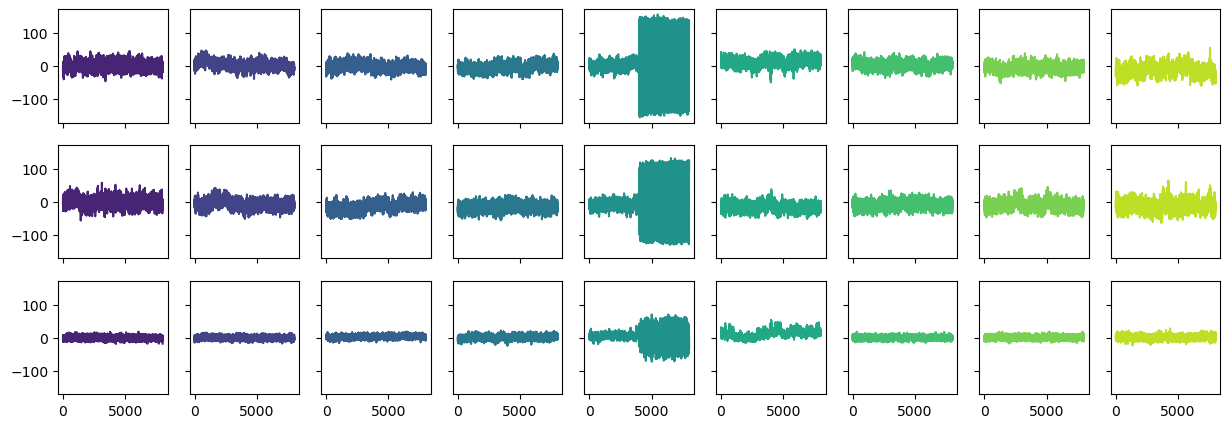

In [75]:

flip_check = True
euler = False
axis_angle = True

# Create an array to store the rotation angles
R = np.zeros((nuc.n_bp,traj.n_frames,3))
             
# Loop over all base pairs             
for idx in range(0,nuc.n_bp):

    # Get the quaternions of the two bases
    q0 = qt.array(np.copy(nuc.quats_A[idx]))
    q1 = qt.array(np.copy(nuc.quats_B[idx]))

    # Check if the quaternions need to be flipped due to double cover
    if flip_check:
        dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)
        mask = dot < 0.0
        q0[mask] = -q0[mask]

    # Calculate the relative rotation between the two bases
    A = q1.inverse*q0

    # Convert the relative rotation to the desired representation
    if axis_angle and not euler:
        # Convert to axis-angle representation
        R[idx] = np.rad2deg(A.to_axis_angle)

    elif euler and not axis_angle:
        # Convert to euler angles representation
        R[idx] = np.rad2deg(A.to_euler_angles)

    else:
        # Convert to rotation matrix
        # Cayley transform?
        pass

# Plot the rotation angles for each base pair
import seaborn as sns
colors = sns.color_palette('viridis',nuc.n_bp)
fig, ax = plt.subplots(3,nuc.n_bp,figsize=(15,5),sharex=True,sharey=True)   
for idx in range(0,nuc.n_bp):
    for jdx in range(3):
        ax[jdx,idx].plot(R[idx].swapaxes(0,1)[jdx],color=colors[idx])

In [ ]:
R = []
R_mid = []
for idx in range(0,nuc.n_bp):
    q0 = nuc.quats_A[idx]
    q1 = nuc.quats_B[idx]
    
    dot = (q0.w*q1.w) + (q0.x*q1.x) + (q0.y*q1.y) + (q0.z*q1.z)
    mask = dot < 0.0
    ax[0].plot(mask, color=colors[idx]) 
    ax[1].plot(dot, color=colors[idx])
    ax[2].plot(q0.w, color=colors[idx])
    ax[3].plot(q1.w, color=colors[idx])
    if check:
        q0[mask] = -q0[mask]

    # if dot < 0.0:
    #     A = -q1.inverse*q0
    #     q_mid = qt.slerp(-q0,q1,0.5)
    # else:
    #     A = q1.inverse*q0
    #     q_mid = qt.slerp(q0,q1,0.5)

    #q1 = qt.array([[-1*q.w, q.x, q.y, q.z ]if m else q for m,q in zip(mask,q1)])
  
    A = q1.inverse*q0
    #A = qt.array([[-1*q.w, q.x, q.y, q.z ]if m else q for m,q in zip(mask,A)])
    angle = 2 * np.arccos(A.w)
    
    a_mask = np.rad2deg(angle) > 179.9
    print(idx,'amask',np.sum(a_mask))   
    ax[4].plot(np.rad2deg(angle), color=colors[idx])
    ax[5].plot(A.w, color=colors[idx])
  
    
    # heading = np.arctan2(2*A.y*A.w-2*A.x*A.z , 1 - 2*A.y**2 - 2*A.z**2)
    # attitude = np.arcsin(2*A.x*A.y + 2*A.z*A.w)
    # bank = np.arctan2(2*A.x*A.w-2*A.y*A.z , 1 - 2*A.x**2 - 2*A.z**2)

    # # pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
    # # yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
    # # roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)

    # #pitch = np.arcsin(2*A.x*A.y + 2*A.z*A.w) # attitude definition 
    

    # pitch = np.arcsin(2.0*(A.w*A.y - A.x*A.z))
    # # yaw = np.arctan2(2.0*(A.y*A.z + A.w*A.x), A.w*A.w - A.x*A.x - A.y*A.y + A.z*A.z)
    # # roll = np.arctan2(2.0*(A.x*A.y + A.w*A.z), A.w*A.w + A.x*A.x - A.y*A.y - A.z*A.z)
    # # # 
    # # # Initialize yaw and roll with default values that will apply when no specific condition is met
    # yaw = np.zeros_like(pitch)
    # roll = np.zeros_like(pitch)

    # # Condition for pitch = pi/2
    # mask_pi_2 = pitch == np.pi/2
    # yaw[mask_pi_2] = -np.arctan2(A.x[mask_pi_2],A.w[mask_pi_2])
    # roll[mask_pi_2] = 0.0

    # # Condition for pitch = -pi/2
    # mask_neg_pi_2 = pitch == -np.pi/2
    # yaw[mask_neg_pi_2] = np.arctan2(A.x[mask_neg_pi_2],A.w[mask_neg_pi_2])
    # roll[mask_neg_pi_2] = 0.0

    # # Default condition (where neither pi/2 nor -pi/2 conditions are met)
    # mask_else = ~(mask_pi_2 | mask_neg_pi_2)
    # yaw[mask_else] = np.arctan2(2.0*(A.y[mask_else]*A.z[mask_else] + A.w[mask_else]*A.x[mask_else]),
    #                             A.w[mask_else]**2 - A.x[mask_else]**2 - A.y[mask_else]**2 + A.z[mask_else]**2)
    # roll[mask_else] = np.arctan2(2.0*(A.x[mask_else]*A.y[mask_else] + A.w[mask_else]*A.z[mask_else]),
    #                             A.w[mask_else]**2 + A.x[mask_else]**2 - A.y[mask_else]**2 - A.z[mask_else]**2)

    # R.append(np.vstack((yaw, pitch, roll)).swapaxes(0,1))
    #R.append(np.vstack((heading, attitude, bank)).swapaxes(0,1))
    #R.append(A.to_axis_angle) 
    R.append(robust_to_axis_angle(A))

ax[4].axhline(180, color='black', linestyle='--')
ax[1].axhline(0, color='black', linestyle='--')

R = np.array(R).swapaxes(0,2)
print(R.shape)
dist = False
fig, ax = plt.subplots(1,nuc.n_bp, figsize=[nuc.n_bp*1.5,1.5],sharex=True,sharey=True)
for i in range(nuc.n_bp):
    if dist:
        sns.kdeplot((np.rad2deg(R[0].T[i])),ax=ax[i],fill=True,cut=0)
    else:
        ax[i].plot(np.rad2deg(R[0].T[i]),color=colors[i])

fig, ax = plt.subplots(1,nuc.n_bp, figsize=[nuc.n_bp*1.5,1.5],sharex=True,sharey=True)
for i in range(nuc.n_bp):
    if dist:
        sns.kdeplot((np.rad2deg(R[1].T[i])),ax=ax[i],fill=True,cut=0)
    else:
        ax[i].plot(np.rad2deg(R[1].T[i]),color=colors[i])

fig, ax = plt.subplots(1,nuc.n_bp, figsize=[nuc.n_bp*1.5,1.5],sharex=True,sharey=True)
for i in range(nuc.n_bp):
    if dist:
        sns.kdeplot((np.rad2deg(R[2].T[i])),ax=ax[i],fill=True,cut=0)
    else:
        ax[i].plot(np.rad2deg(R[2].T[i]),color=colors[i])

